<a href="https://colab.research.google.com/github/HomeschoolHarry/forecast_testing_Darts/blob/main/simple_sales_forecasting_iowaLiquorAPI_titos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs and Imports

## <u>Comparing Darts forecasting models against Tito Vodka sales in Iowa <u>


API to Iowa Liquor Database:
- Link to Iowa API: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy
- Link to seperate technical write up that was previously published with imformation on dataset and SODA API:https://medium.com/@harry.mckaig/building-a-data-pipeline-from-the-iowa-liquor-sales-open-database-using-socrata-open-data-api-f21875dd6f2c

API will grab
- Tito's (750mL bottle, 12 pack ONLY) sales and volume
- All Other (A/O): total sales and volume

- Sales it total retail dollars (retail bottle price * number of bottles sold)
- Volume is total liters sold (converted to standard 9L cases)

In [2]:
import os

In [3]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting req

In [3]:
import numpy as np
import requests
import seaborn as sns
import pandas as pd
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [4]:
#grab Tito's and All-Other A/O category sales
url = f"https://data.iowa.gov/resource/m3tr-qhgy.json?$select=date_trunc_ym(date) as date,itemno='38176' as tito_750,sum(sale_dollars) as sales,sum(sale_liters) as volume&$group=date,tito_750"
response = requests.get(url)
response.raise_for_status()

# To save as Pandas DataFrame
titos = response.json()
titos = pd.DataFrame(titos)

#convert types
convert_dict = {'date': object,
                'sales': float,
                'volume': float,
                }
titos = titos.astype(convert_dict)

# use numpy to convert year and month to datetime
titos['date'] = pd.to_datetime(titos['date'])

# grab 750 ml using True value
tito_750_only = titos[titos['tito_750'] == True]
#drop the boolean column
tito_750_only = tito_750_only.drop('tito_750', axis=1)

#grab all-other sales
ao_sales = titos[titos['tito_750'] == False]
ao_sales = ao_sales.drop('tito_750', axis=1)

# Volume DataFrames
df_tito_volume = tito_750_only[['date', 'volume']]
df_ao_volume = ao_sales[['date', 'volume']]

Convert to 9L

In [5]:
# convert to standard 9L cases
def conv_nine(row):
  return (row['volume'] / 9).round(decimals=0)

df_tito_volume['volume (9L)'] = conv_nine(df_tito_volume)
df_ao_volume['volume (9L)'] = conv_nine(df_ao_volume)

df_tito_volume = df_tito_volume.drop(columns='volume')
df_ao_volume = df_ao_volume.drop(columns='volume')


In [6]:
df_tito_volume

,date,volume (9L)
1,2012-01-01,58.0
3,2012-02-01,117.0
5,2012-03-01,93.0
7,2012-04-01,108.0
9,2012-05-01,195.0
...,...,...
259,2022-10-01,2883.0
261,2022-11-01,2479.0
263,2022-12-01,4055.0
265,2023-01-01,2248.0


In [7]:
# Convert sales to Series
series_tito_sales = TimeSeries.from_dataframe(tito_750_only,time_col='date')
series_ao_sales = TimeSeries.from_dataframe(ao_sales, time_col='date')

# Volume DataFrames
series_tito_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')
series_ao_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')


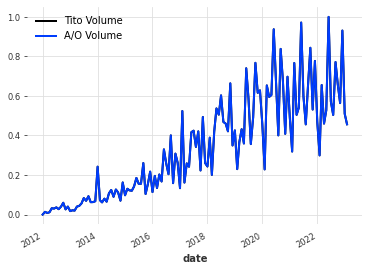

In [8]:
scaler_tito, scaler_ao = Scaler(), Scaler()
series_tito_scaled = scaler_tito.fit_transform(series_tito_volume)
series_ao_scaled = scaler_ao.fit_transform(series_ao_volume)

series_tito_scaled.plot(label="Tito Volume")
series_ao_scaled.plot(label="A/O Volume")
plt.legend();

## Training / Test Split

We want to test out 6 months and will take length of series, subtract 6 for the train /test split

In [9]:
len(series_ao_volume)

134

In [10]:
from datetime import datetime
now = datetime.now()

In [11]:
series_tito_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')
series_ao_volume = TimeSeries.from_dataframe(df_tito_volume, time_col='date')

In [1]:
series_tito_volume

NameError: ignored

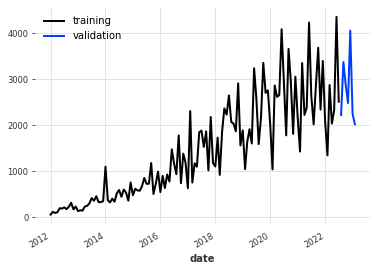

In [12]:
#Tito's 750mL only 
train, val = series_tito_volume.split_before(pd.Timestamp("20220801"))
train.plot(label="training")
val.plot(label="validation")

## Naive - Random Walk Model

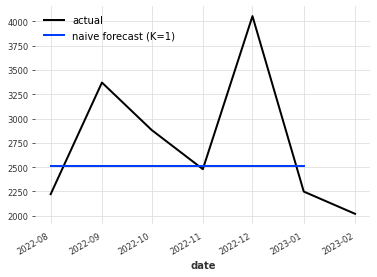

In [13]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)

# The fit() function takes in argument the training time series on which to fit the model
naive_model.fit(train)

# the predict() function takes an argument, the number of time steps (after the end of the training series) over which to forecast.
# the number of stepts in this model will be in months, we want 6
naive_forecast = naive_model.predict(6)

val.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

## Naive - Random Walk Model w/ Seasonality

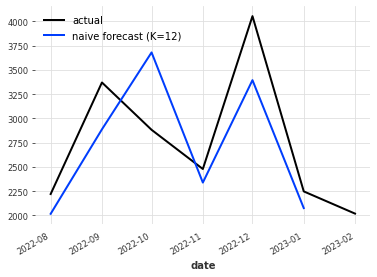

In [14]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(6)

val.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

## Naive - Random Walk Model w/ Seasonality + Drift
- This model simply produces linear predictions, with a slope that is determined by the first and last values of the training set

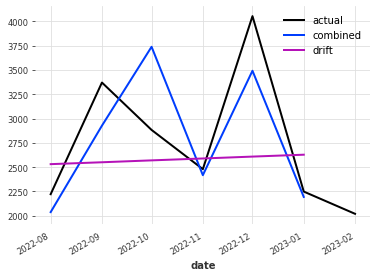

In [15]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(6)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

val.plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [16]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(val, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 11.67%.


In [17]:
# naive_results = pd.Series()
# naive_results['actual'] = val
# naive_results['naive'] = naive_forecast
# naive_results['naive seasonal'] = seasonal_forecast
# naive_results['combined'] = combined_forecast


In [52]:
#naive_forecast
#seasonal_forecast
#combined_forecast

<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)>
array([[[2036.46825397]],

       [[2926.93650794]],

       [[3739.4047619 ]],

       [[2416.87301587]],

       [[3492.34126984]],

       [[2192.80952381]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-08-01 2022-09-01 ... 2023-01-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [23]:
#Save Initial Forecast
#df_tito_volume.to_csv('tito_volume.csv')

In [55]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))
    print(forecast)


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())



model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 12.33%
<TimeSeries (DataArray) (date: 7, component: 1, sample: 1)>
array([[[2107.06964585]],

       [[3140.62613272]],

       [[3677.8692429 ]],

       [[2403.24141377]],

       [[3422.88803631]],

       [[2210.23461612]],

       [[1484.63855364]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-08-01 2022-09-01 ... 2023-02-01
  * component  (component) object 'volume (9L)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
model (T)BATS obtains MAPE: 24.71%
<TimeSeries (DataArray) (date: 7, component: 1, sample: 1)>
array([[[3747.09982992]],

       [[3607.12342605]],

       [[3308.48264887]],

       [[2956.89007047]],

       [[2652.73343694]],

       [[2460.00497161]],

       [[2407.36090388]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-08-01 2022-09-01 ... 2023

FINDING BEST THETA

In [57]:
# # Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)



The MAPE is: 13.71, with theta = 0.5714285714285712.


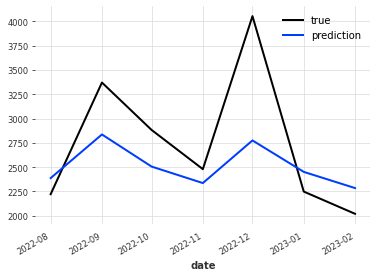

In [59]:

#train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

100%|██████████| 50/50 [00:01<00:00, 30.17it/s]


MAPE = 29.11%


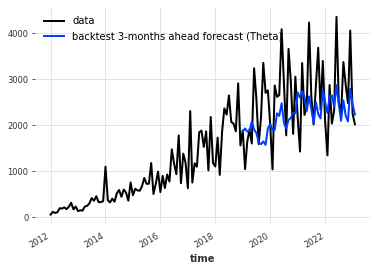

In [65]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series_tito_volume, start=0.6, forecast_horizon=6, verbose=True
)

series_tito_volume.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series_tito_volume)))